In [ ]:
from models.LSTM import LSTMModel
from models.Informer import Informer
from models.GWNet import GWNet
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import tqdm 

In [3]:
# import site


if False:
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split

    # 假设你已经读取了数据到 DataFrame df
    print("Loading dataset...")
    MINI = True
    COMBINE_VMID = True # 是否将VMID作为一个额外的维度
    INPUT_SEQ_LEN = 20 # 输入序列长度
    OUTPUT_SEQ_LEN = 1 # 输出序列长度
    chunksize = 10000000
    chunk_limit = 25 if not MINI else 3
    data_limit = 1000 if MINI else -1
    count_data = 0
    X, y = [], []
    iter = 0
    SELECT_VMID_NUM = 200
    selected_vmid = []
    selected_vmid_to_site_id = {}
    total_df = []
    for chunk in pd.read_csv("dataset/fromCloudToEdge/VM_CPU.csv", chunksize=chunksize, low_memory=False):
        print(f"Processing chunk {iter}...")
        iter += 1
        if iter > chunk_limit:
            break
        chunk['timestamp'] = pd.to_datetime(chunk['report_ts'], unit='s')
        # df = pd.DataFrame(data)
        # chunk.head()
        # 按虚拟机ID分组
        print(len(chunk['vm_id'].unique()), "VMs in chunk")
        grouped = chunk.groupby('vm_id')
        if iter == 1:
            # 仅在第一次迭代时选择虚拟机ID
            vm_ids = chunk['vm_id'].unique()
            if len(vm_ids) > SELECT_VMID_NUM:
                selected_vmid = np.random.choice(vm_ids, SELECT_VMID_NUM, replace=False)
                
            else:
                selected_vmid = vm_ids
            for vmid in selected_vmid:
                site_id = chunk[chunk['vm_id'] == vmid]['site_id'].values[0]
                selected_vmid_to_site_id[vmid] = site_id
            print(f"Selected {len(selected_vmid)} VMIDs for processing.")
        total_df.append(chunk[chunk['vm_id'].isin(selected_vmid)])
    df = pd.concat(total_df, ignore_index=True)
    print(f"Total VMs in dataset: {len(df['vm_id'].unique())}")
    print(f"Total data points: {len(df)}")
    grouped = df.groupby('vm_id')
    if COMBINE_VMID:
        
        # 仅处理选定的虚拟机ID
        df = df[df['vm_id'].isin(selected_vmid)]
        x_vmid_sequences = {}
        y_vmid_sequences = {}
        vmid_sequences = {}
        # dataset x shape = (data_num, num_vmids, input_seq_len, 1)
        # dataset y shape = (data_num, num_vmids, output_seq_len, 1)
        for vmid, group in grouped:
            group = group.sort_values('timestamp')
            cpu_usage = group['cpu_rate'].values
            # cpu_usage = cpu_usage.reshape(-1, 1)  # 确保是二维数组
            # 初始化 vmid 的列表
            if vmid not in vmid_sequences:
                vmid_sequences[vmid] = []
                x_vmid_sequences[vmid] = []
                y_vmid_sequences[vmid] = []

            # 收集序列
            for i in range(len(cpu_usage) - INPUT_SEQ_LEN - OUTPUT_SEQ_LEN + 1):
                x_vmid_sequences[vmid].append(cpu_usage[i:i + INPUT_SEQ_LEN])
                y_vmid_sequences[vmid].append(cpu_usage[i + INPUT_SEQ_LEN:i + INPUT_SEQ_LEN + OUTPUT_SEQ_LEN])
        vmid_num = len(vmid_sequences)
        all_sequences_x = []
        all_sequences_y = []
        common_length = min(len(x_vmid_sequences[vmid]) for vmid in vmid_sequences)
        if common_length < 1:
            # remove vmid_sequences with less than 1 sequence
            x_vmid_sequences = {vmid: seq for vmid, seq in x_vmid_sequences.items() if len(seq) >= 1}
            for vmid in vmid_sequences:
                if vmid not in x_vmid_sequences:
                    del y_vmid_sequences[vmid]
            # 重新计算 vmid_num 和 common_length
            vmid_sequences = x_vmid_sequences.keys()
            selected_vmid = list(vmid_sequences)
            vmid_num = len(vmid_sequences)
            if vmid_num == 0:
                print("No valid VMIDs with sufficient data.")
                exit(0)
            print(f"After filtering, {vmid_num} VMIDs have sufficient data.")
            
            common_length = min(len(x_vmid_sequences[vmid]) for vmid in vmid_sequences)
            
            
        for vmid in vmid_sequences:
            # 确保每个 vmid 的序列长度一致
            x_vmid_sequences[vmid] = x_vmid_sequences[vmid][:common_length]
            y_vmid_sequences[vmid] = y_vmid_sequences[vmid][:common_length]
            all_sequences_x.append(np.array(x_vmid_sequences[vmid]))
            all_sequences_y.append(np.array(y_vmid_sequences[vmid]))
        # 将所有 vmid 的序列堆叠在一起
        X = np.stack(all_sequences_x, axis=1)  # shape = (data_num, num_vmids, input_seq_len, 1)
        y = np.stack(all_sequences_y, axis=1)
        count_data += common_length
        print(f"Processed {common_length} sequences for {vmid_num} VMs in this chunk.")
            
        
    else:
        # dataset x shape = (data_num,  input_seq_len, 1)
        # dataset y shape = (data_num,  output_seq_len, 1)
        for vm_id, group in grouped:
            group = group.sort_values('timestamp')
            cpu_usage = group['cpu_rate'].values
            if len(cpu_usage) < INPUT_SEQ_LEN + OUTPUT_SEQ_LEN:
                continue
            for i in range(len(cpu_usage) - INPUT_SEQ_LEN - OUTPUT_SEQ_LEN + 1):
                X.append(cpu_usage[i:i + INPUT_SEQ_LEN])
                y.append(cpu_usage[i + INPUT_SEQ_LEN:i + INPUT_SEQ_LEN + OUTPUT_SEQ_LEN])
                count_data += 1
                if count_data >= data_limit > 0:
                    break
            if count_data >= data_limit > 0:
                break
    X = np.array(X)
    print(f"X shape: {X.shape}")
    y = np.array(y)
    print(f"y shape: {y.shape}")

    # 划分训练集、测试集、验证集
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)
    category=['train', 'val', 'test']
    # 保存为 .npz 文件
    for cate in category:
        np.savez(f'dataset/fromCloudToEdge/{"split_CPU" if not MINI else "mini_split"}/{cate}.npz',
                x=X_train if cate == 'train' else (X_val if cate == 'val' else X_test),
                y=y_train if cate == 'train' else (y_val if cate == 'val' else y_test))
    if COMBINE_VMID:
        # print vmid to txt
        ignore_dot = True
        with open(f'dataset/fromCloudToEdge/{"split_CPU" if not MINI else "mini_split"}/vmid.txt', 'w') as f:
            for vmid in selected_vmid:
                if ignore_dot:
                    ignore_dot = False
                else:
                    f.write(',')
                f.write(f"{vmid}")
                
        # get all site_id of each vmid from VM.csv
        # vmid_to_site = {}
        # site_id_to_vmid = {}
        # vmid_df = pd.read_csv("dataset/fromCloudToEdge/VM.csv")
        # for vmid in selected_vmid:
        #     site_id = vmid_df[vmid_df['vm_id'] == vmid]['site_id']
        #     if len(site_id) == 0:
        #         print(f"VMID {vmid} not found in VM.csv")
        #         continue
        #     site_id = site_id.values[0]
        #     vmid_to_site[vmid] = site_id
        #     site_id_to_vmid[site_id] = site_id_to_vmid.get(site_id, []) + [vmid]
        all_site_ids =  set(selected_vmid_to_site_id.values())
        # from SITE_RTT.csv generate from, to, dstance(adj matrix)
        rtt_df = None
        TARGET_CSV = f'dataset/fromCloudToEdge/{"split_CPU" if not MINI else "mini_split"}/distance.csv'
        with open(TARGET_CSV, 'w') as f:
            f.write("from,to,distance\n")
            for chunk in pd.read_csv("dataset/fromCloudToEdge/SITE_RTT.csv", chunksize=chunksize, low_memory=False):
                # there is lot of data in time series, we only get all the first data of all the site_id needed
                chunk = chunk[chunk['from_site_id'].isin(all_site_ids)]
                chunk = chunk[chunk['to_site_id'].isin(all_site_ids)]
                chunk = chunk.drop_duplicates(subset=['from_site_id', 'to_site_id'])
                if rtt_df is None:
                    rtt_df = chunk
                    break
            rtt_mean = rtt_df['rtt'].mean()
            rtt_std = rtt_df['rtt'].std()
            # generate adj matrix 
            # adj_matrix = np.zeros((selected_vmid.shape[0], selected_vmid.shape[0]))
            for vmid in selected_vmid:
                from_site_id = selected_vmid_to_site_id[vmid]
                # from_index = all_site_ids.index(site_id)
                for to_vmid in selected_vmid:
                    distance = -1
                    if to_vmid == vmid:
                        distance = 0
                    else:
                        to_site_id = selected_vmid_to_site_id[to_vmid]
                        if from_site_id == to_site_id:
                            distance = 0
                        else:
                            # get distance from SITE_RTT.csv
                            rtt = rtt_df[(rtt_df['from_site_id'] == from_site_id) & (rtt_df['to_site_id'] == to_site_id)]['rtt'].values
                            if len(rtt) > 0:
                                distance = rtt[0]
                            else:
                                rtt = rtt_df[(rtt_df['from_site_id'] == to_site_id) & (rtt_df['to_site_id'] == from_site_id)]['rtt'].values
                                if len(rtt) > 0:
                                    distance = rtt[0]
                                else:
                                    distance = rtt_mean + np.random.normal(0, rtt_std)
                f.write(f"{vmid},{to_vmid},{distance}\n")

                
                
            
            
    print(f"generated {count_data} data points with {X.shape[1]} features each.")
    # np.savez('dataset/fromCloudToEdge/split_CPU/time_series_data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, X_val=X_val, y_val=y_val)


Loading dataset...
Processing chunk 0...
Selected 200 VMIDs for processing.
Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Total VMs in dataset: 200
Total data points: 777406
Selecting data from 2020-06-03 16:00:00 to 2020-06-04 16:00:00


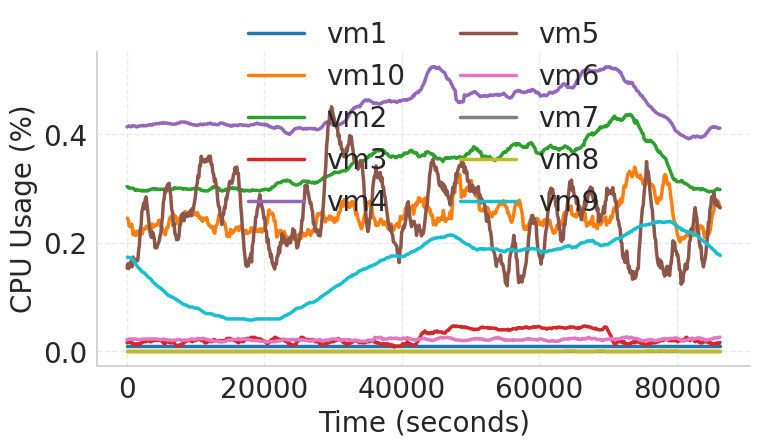

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Loading dataset...")
MINI = True
COMBINE_VMID = True
INPUT_SEQ_LEN = 20
OUTPUT_SEQ_LEN = 1
chunksize = 10000000
chunk_limit = 25 if not MINI else 3
SELECT_VMID_NUM = 200
iter = 0
selected_vmid = []
selected_vmid_to_site_id = {}
total_df = []

for chunk in pd.read_csv("dataset/fromCloudToEdge/VM_CPU.csv", chunksize=chunksize, low_memory=False):
    print(f"Processing chunk {iter}...")
    iter += 1
    if iter > chunk_limit:
        break
    chunk['timestamp'] = pd.to_datetime(chunk['report_ts'], unit='s')
    grouped = chunk.groupby('vm_id')
    if iter == 1:
        vm_ids = chunk['vm_id'].unique()
        if len(vm_ids) > SELECT_VMID_NUM:
            selected_vmid = np.random.choice(vm_ids, SELECT_VMID_NUM, replace=False)
        else:
            selected_vmid = vm_ids
        for vmid in selected_vmid:
            site_id = chunk[chunk['vm_id'] == vmid]['site_id'].values[0]
            selected_vmid_to_site_id[vmid] = site_id
        print(f"Selected {len(selected_vmid)} VMIDs for processing.")
    total_df.append(chunk[chunk['vm_id'].isin(selected_vmid)])

df = pd.concat(total_df, ignore_index=True)
print(f"Total VMs in dataset: {len(df['vm_id'].unique())}")
print(f"Total data points: {len(df)}")

df['timestamp'] = pd.to_datetime(df['report_ts'], unit='s')
start_date = df['timestamp'].min()
end_date = pd.to_datetime(start_date + pd.Timedelta(days=1))
print(f"Selecting data from {start_date} to {end_date}")
df = df[(df['timestamp'] >= start_date) & (df['timestamp'] < end_date)]

selected_vmid = np.random.choice(df['vm_id'].unique(), 10, replace=False)
df = df[df['vm_id'].isin(selected_vmid)]
df['cpu_rate'] = df['cpu_rate'].astype(float)
df = df.sort_values(by=['vm_id', 'timestamp'])

# 修改vm_id为vm1...vm10
vmid_map = {vmid: f'vm{idx+1}' for idx, vmid in enumerate(selected_vmid)}
df['vm_id'] = df['vm_id'].map(vmid_map)

# 将时间戳转为从0开始的数值
df['time_idx'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
df['time_idx'] = df['time_idx'].astype(int)

SIGCOMM_COLORS = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]
sns.set_style('whitegrid')
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

plt.figure(figsize=(8, 5))
for idx, vmid in enumerate(sorted(df['vm_id'].unique())):
    vm_df = df[df['vm_id'] == vmid]
    vm_df = vm_df.sort_values(by='time_idx')
    smooth_cpu = vm_df['cpu_rate'].rolling(window=10, min_periods=1, center=True).mean()
    plt.plot(vm_df['time_idx'], smooth_cpu,
             label=vmid,
             color=SIGCOMM_COLORS[idx % len(SIGCOMM_COLORS)],
             linewidth=2.5)

plt.xlabel('Time (seconds)', fontsize=20)
plt.ylabel('CPU Usage (%)', fontsize=20)
plt.legend(frameon=False, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.18))
plt.grid(True, linestyle='--', linewidth=1, alpha=0.4)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig('fig-exp-task-trace-com.pdf', bbox_inches='tight', dpi=300)
plt.show()
# dump the data
df.to_csv('selected_vms_cpu_usage.csv', index=False)

Loading dataset...
Processing chunk 0...
12221 VMs in chunk
Selected 200 VMIDs for processing.
Processing chunk 1...
9654 VMs in chunk
Total VMs in dataset: 200
Total data points: 280583
Selecting data from 2020-06-01 00:00:00 to 2020-06-02 00:00:00


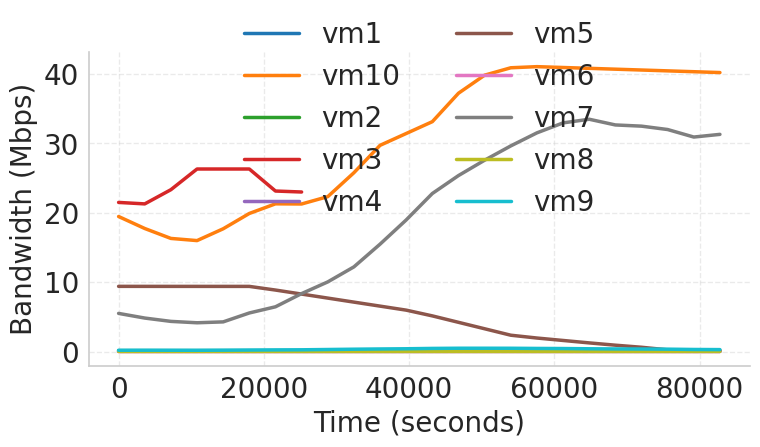

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Loading dataset...")
MINI = True
COMBINE_VMID = True
INPUT_SEQ_LEN = 20
OUTPUT_SEQ_LEN = 1
chunksize = 10000000
chunk_limit = 25 if not MINI else 3
SELECT_VMID_NUM = 200
iter = 0
selected_vmid = []
selected_vmid_to_site_id = {}
total_df = []

for chunk in pd.read_csv("dataset/fromCloudToEdge/VM_BW_THREE_MONTHS.csv", chunksize=chunksize, low_memory=False):
    print(f"Processing chunk {iter}...")
    iter += 1
    if iter > chunk_limit:
        break
    chunk['timestamp'] = pd.to_datetime(chunk['report_time'])
    print(len(chunk['vm_id'].unique()), "VMs in chunk")
    grouped = chunk.groupby('vm_id')
    if iter == 1:
        vm_ids = chunk['vm_id'].unique()
        if len(vm_ids) > SELECT_VMID_NUM:
            selected_vmid = np.random.choice(vm_ids, SELECT_VMID_NUM, replace=False)
        else:
            selected_vmid = vm_ids
        print(f"Selected {len(selected_vmid)} VMIDs for processing.")
    total_df.append(chunk[chunk['vm_id'].isin(selected_vmid)])

df = pd.concat(total_df, ignore_index=True)
print(f"Total VMs in dataset: {len(df['vm_id'].unique())}")
print(f"Total data points: {len(df)}")

df['timestamp'] = pd.to_datetime(df['report_time'])
df['pub_down_bw'] = df['pub_down_bw'].astype(float)
df['pub_down_Mbps'] = df['pub_down_bw'] / 1e6  # 转换为Mbps
start_date = df['timestamp'].min()
end_date = pd.to_datetime(start_date + pd.Timedelta(days=1))
print(f"Selecting data from {start_date} to {end_date}")
df = df[(df['timestamp'] >= start_date) & (df['timestamp'] < end_date)]
df = df[df['pub_down_Mbps'] > 0]
df = df[df['pub_down_Mbps'] < 50]

selected_vmid = np.random.choice(df['vm_id'].unique(), 10, replace=False)
df = df[df['vm_id'].isin(selected_vmid)]
df = df.sort_values(by=['vm_id', 'timestamp'])

# 修改df的vm_id为vm1...vm10
vmid_map = {vmid: f'vm{idx+1}' for idx, vmid in enumerate(selected_vmid)}
df['vm_id'] = df['vm_id'].map(vmid_map)

# 将时间戳转为从0开始的数值
df['time_idx'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds()
df['time_idx'] = df['time_idx'].astype(int)

SIGCOMM_COLORS = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]
sns.set_style('whitegrid')
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

plt.figure(figsize=(8, 5))
for idx, vmid in enumerate(sorted(df['vm_id'].unique())):
    vm_df = df[df['vm_id'] == vmid]
    vm_df = vm_df.sort_values(by='time_idx')
    smooth_bw = vm_df['pub_down_Mbps'].rolling(window=10, min_periods=1, center=True).mean()
    plt.plot(vm_df['time_idx'], smooth_bw,
             label=vmid,
             color=SIGCOMM_COLORS[idx % len(SIGCOMM_COLORS)],
             linewidth=2.5)

plt.xlabel('Time (seconds)', fontsize=20)
plt.ylabel('Bandwidth (Mbps)', fontsize=20)
plt.legend(frameon=False, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.18), fontsize=20)
plt.grid(True, linestyle='--', linewidth=1, alpha=0.4)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig('bw_usage_selected_vms_SIGCOMM.pdf', bbox_inches='tight', dpi=300)
plt.show()
df.to_csv('selected_vms_bw_usage.csv', index=False)


In [6]:
class StandardScaler():

    def __init__(self, mean, std, fill_zeroes=True):
        self.mean = mean
        self.std = std
        self.fill_zeroes = fill_zeroes

    def transform(self, data):
        if self.fill_zeroes:
            mask = (data == 0)
            data[mask] = self.mean
        return (data - self.mean) / self.std

    def inverse_transform(self, data):
        return (data * self.std) + self.mean
    
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).unsqueeze(-1)  # [batch, seq_len, 1]
        self.y = torch.tensor(y).unsqueeze(-1)  # [batch, 1]
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def load_dataset(dataset_dir, batch_size, valid_batch_size=None, test_batch_size=None, n_obs=None, fill_zeroes=True):
    data = {}
    for category in ['train', 'val', 'test']:
        cat_data = np.load(os.path.join(dataset_dir, category + '.npz'))
        # change float64 to float32
        cat_data = {k: v.astype(np.float32) for k, v in cat_data.items()}
        if 'x' not in cat_data or 'y' not in cat_data:
            raise ValueError(f"Data for category '{category}' must contain 'x' and 'y' keys.")
        data['x_' + category] = cat_data['x']
        data['y_' + category] = cat_data['y']
        if n_obs is not None:
            data['x_' + category] = data['x_' + category][:n_obs]
            data['y_' + category] = data['y_' + category][:n_obs]
    scaler = StandardScaler(mean=data['x_train'][..., 0].mean(), std=data['x_train'][..., 0].std(), fill_zeroes=fill_zeroes)
    # Data format
    for category in ['train', 'val', 'test']:
        data['x_' + category][..., 0] = scaler.transform(data['x_' + category][..., 0])
    train_ds = TimeSeriesDataset(data['x_train'], data['y_train'])
    val_ds = TimeSeriesDataset(data['x_val'], data['y_val'])
    test_ds = TimeSeriesDataset(data['x_test'], data['y_test'])
    data['train_loader'] = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    data['val_loader'] = DataLoader(val_ds, batch_size=valid_batch_size, shuffle=False, drop_last=True)
    data['test_loader'] = DataLoader(test_ds, batch_size=test_batch_size, shuffle=False, drop_last=True)
    # Store scaler for inverse transformation
    data['scaler'] = scaler
    return data

In [7]:


def mask_and_fillna(loss, mask):
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)
def calc_metrics(preds, labels, null_val=0.):
    
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean(mask)
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    mse = (preds - labels) ** 2
    mae = torch.abs(preds-labels)
    mape = mae / labels
    mae, mape, mse = [mask_and_fillna(l, mask) for l in [mae, mape, mse]]
    rmse = torch.sqrt(mse)
    return mae, mape, rmse

class Trainer():
    def __init__(self, model, scaler, lrate, wdecay, clip=3, lr_decay_rate=.97):
        self.model = model

        self.optimizer = optim.Adam(self.model.parameters(), lr=lrate, weight_decay=wdecay)
        self.scaler = scaler
        self.clip = clip
        self.scheduler = optim.lr_scheduler.LambdaLR(
            self.optimizer, lr_lambda=lambda epoch: lr_decay_rate ** epoch)

    @classmethod
    def from_args(cls, model, scaler, args):
        return cls(model, scaler, args.learning_rate, args.weight_decay, clip=args.clip,
                   lr_decay_rate=args.lr_decay_rate)

    def train(self, input, real_val, tranponse=False, LSTM=False):
        self.model.train()
        self.optimizer.zero_grad()
        # if tranponse:
        #     input = nn.functional.pad(input,(1,0,0,0))
        output = self.model(input)  # now, output = [batch_size,1,num_nodes, seq_length]
        if tranponse:
            pass
        if LSTM:
            output = output.unsqueeze(-1)
            output = output.transpose(2, 1)
            # output = output.transpose(2, 1)
        # print(f"predict = {output.shape}, realval = {real_val.shape}")
        
        predict = self.scaler.inverse_transform(output)
        assert predict.shape[1] == 1
        # print(f"predict = {output.shape}, realval = {real_val.shape}")
        mae, mape, rmse = calc_metrics(predict.squeeze(1), real_val, null_val=0.0)
        mae.backward()
        if self.clip is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip)
        self.optimizer.step()
        return mae.item(),mape.item(),rmse.item()

    def eval(self, input, real_val, tranponse=False):
        self.model.eval()
        # if tranponse:
        #     input = nn.functional.pad(input,(1,0,0,0))
        # input = nn.functional.pad(input,(1,0,0,0))
        output = self.model(input) #  [batch_size,seq_length,num_nodes,1]
        real = torch.unsqueeze(real_val,dim=1)
        predict = self.scaler.inverse_transform(output)
        # print(predict.shape, real_val.shape)

        # predict = torch.clamp(predict, min=0., max=70.)
        mae, mape, rmse = [x.item() for x in calc_metrics(predict, real, null_val=0.0)]
        return mae, mape, rmse


In [8]:
TRAINING_LSTM = True
TRAINING_INFORMER = True
TRAINING_GWNET = True
TRAINING_ELASTIC = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# if TRAINING_LSTM:
# Load dataset
dataset_dir = 'dataset/fromCloudToEdge/mini_split'
batch_size = 64
valid_batch_size = 64
test_batch_size = 64
n_obs = None  # Use all observations
data = load_dataset(dataset_dir, batch_size, valid_batch_size, test_batch_size, n_obs)

train_loader = data['train_loader']
val_loader = data['val_loader']
test_loader = data['test_loader']
scaler = data['scaler']
print("Dataset loaded successfully.")
iter = 0
for iter, (x, y) in enumerate(data['train_loader']):
    if iter == 0:
        print(f"Train data shape: {x.shape}, {y.shape}")
        # exit(0)
        break
   

Dataset loaded successfully.
Train data shape: torch.Size([64, 199, 20, 1]), torch.Size([64, 199, 1, 1])


In [10]:
if TRAINING_LSTM:
     # Initialize model
    model = LSTMModel(input_size=199, hidden_size=64, num_layers=2).to(device)
    print("LSTM Model initialized successfully.")
    # Initialize trainer
    EPOCH = 100
    trainer = Trainer.from_args(model, scaler, args=type('', (), {'learning_rate': 0.001, 'weight_decay': 1e-5, 'clip': 3, 'lr_decay_rate': 0.97}))
    print("Trainer initialized successfully.")
    # Training loop
    train_loss, train_mape, train_rmse = [], [], []
    val_loss, val_mape, val_rmse = [], [], []
    lowest_mae = float('inf')
    with tqdm.tqdm(total=EPOCH * len(train_loader)) as pbar:
        for epoch in range(EPOCH):
            for i, (input, real_val) in enumerate(train_loader):
                # input, real_val = input.astype(torch.float32), real_val.astype(torch.float32)
                input, real_val = input.to(device), real_val.to(device)
                input =input.squeeze(-1)
                real_val =real_val.squeeze(-1)
                input = input.transpose(1, 2)
                real_val = real_val.transpose(1, 2)
                # print(f"input shape: {input.shape}, real_val shape: {real_val.shape}")
                mae, mape, rmse = trainer.train(input, real_val, LSTM=True)
                train_loss.append(mae)
                train_mape.append(mape)
                train_rmse.append(rmse)
                pbar.update(1)
            trainer.scheduler.step()
            # Evaluate on validation set
            with torch.no_grad():
                for i, (input, real_val) in enumerate(val_loader):
                    # input, real_val = input.astype(torch.float32), real_val.astype(torch.float32)
                    
                    input, real_val = input.to(device), real_val.to(device)
                    input =input.squeeze(-1)
                    real_val =real_val.squeeze(-1)
                    input = input.transpose(1, 2)
                    real_val = real_val.transpose(1, 2)
                    
                    mae, mape, rmse = trainer.eval(input, real_val)
                    val_loss.append(mae)
                    val_mape.append(mape)
                    val_rmse.append(rmse)
            # Check if current validation loss is the lowest
            if np.mean(val_mape) < lowest_mae:
                lowest_mae = np.mean(val_mape)
                torch.save(model.state_dict(), 'best_model.pth')
                # print(f"New best model saved at epoch {epoch+1} with MAPE: {lowest_mae:.4f}")
            
            # print(f"Epoch {epoch+1}/{EPOCH}, Train Loss: {np.mean(train_loss):.4f}, Train MAPE: {np.mean(train_mape):.4f}, Train RMSE: {np.mean(train_rmse):.4f}")
    print(f"Training completed. Final Train Loss: {train_loss[-1]:.4f}, Train MAPE: {train_mape[-1]:.4f}, Train RMSE: {train_rmse[-1]:.4f}")
    
    # # test
    # model.load_state_dict(torch.load('best_model.pth'))
    # realy = 
    

LSTM Model initialized successfully.
Trainer initialized successfully.


 37%|███▋      | 262/700 [00:01<00:01, 221.59it/s]


KeyboardInterrupt: 

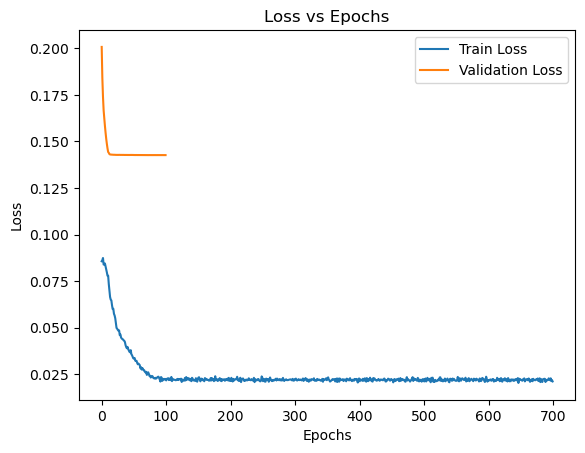

(12736,) (12736,)


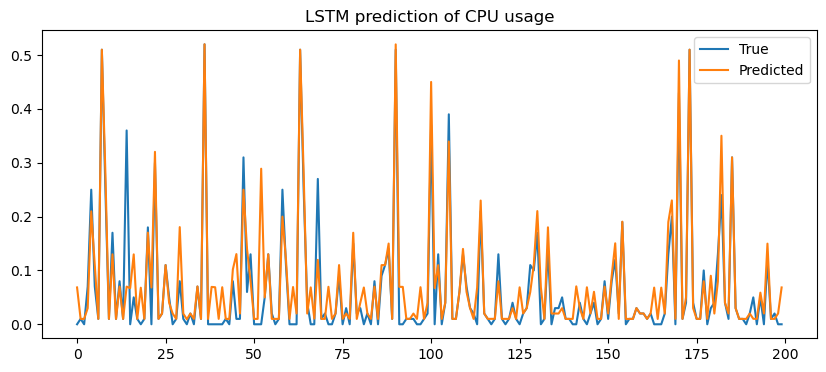

In [ ]:
if TRAINING_LSTM:
    true_y = []
    pred_y = []
    with torch.no_grad():
        for i, (input, real_val) in enumerate(val_loader):
            # input, real_val = input.astype(torch.float32), real_val.astype(torch.float32)
            
            input, real_val = input.to(device), real_val.to(device)
            input =input.squeeze(-1)
            real_val =real_val.squeeze(-1)
            input = input.transpose(1, 2)
            real_val = real_val.transpose(1, 2)
            trainer.model.eval()
            # input = nn.functional.pad(input,(1,0,0,0))
            output = trainer.model(input) #  [batch_size,seq_length,num_nodes,1]
            real_val = real_val.squeeze(1)
            predict = trainer.scaler.inverse_transform(output)
            predict = predict.cpu().numpy()
            real_val = real_val.cpu().numpy()
            true_y.append(real_val)
            pred_y.append(predict)
            break
    
    y_pred_rescaled = np.concatenate(pred_y, axis=0)
    y_test_rescaled = np.concatenate(true_y, axis=0)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.figure(figsize=(10, 4))
    y_pred_rescaled =  y_pred_rescaled.flatten()
    y_test_rescaled =  y_test_rescaled.flatten()  # 合并测试结果
    print(y_pred_rescaled.shape, y_test_rescaled.shape)
    y_pred_rescaled = np.clip(y_pred_rescaled, 0, 1)
    y_test_rescaled = np.clip(y_test_rescaled, 0, 1)
    plt.plot(y_test_rescaled[:200], label='True')
    plt.plot(y_pred_rescaled[:200], label='Predicted')
    plt.legend()
    plt.title('LSTM prediction of CPU usage')
    plt.show()

In [ ]:
if TRAINING_INFORMER:
    input_size = 199  # Number of features
    embed_size = 256  # Embedding size
    hidden_size = 512  # Hidden size (not directly used in this model)
    num_layers = 4  # Number of encoder layers
    num_heads = 8  # Number of attention heads
    ff_hid_dim = 2048  # Feedforward hidden dimension
    dropout = 0.1  # Dropout rate

    model = Informer(input_size=input_size, embed_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, num_heads=num_heads, ff_hid_dim=ff_hid_dim, dropout=dropout).to(device)

    print("Informer model initialized successfully.")
    # Initialize trainer
    EPOCH = 100
    trainer = Trainer.from_args(model, scaler, args=type('', (), {'learning_rate': 0.001, 'weight_decay': 1e-5, 'clip': 3, 'lr_decay_rate': 0.97}))
    print("Trainer initialized successfully.")
    # Training loop
    train_loss, train_mape, train_rmse = [], [], []
    val_loss, val_mape, val_rmse = [], [], []
    lowest_mae = float('inf')
    with tqdm.tqdm(total=EPOCH * len(train_loader)) as pbar:
        for epoch in range(EPOCH):
            for i, (input, real_val) in enumerate(train_loader):
                input, real_val = input.to(device), real_val.to(device)
                input =input.squeeze(-1)
                real_val =real_val.squeeze(-1)
                input = input.transpose(1, 2)
                real_val = real_val.transpose(1, 2)
                # print(f"input shape: {input.shape}, real_val shape: {real_val.shape}")
                mae, mape, rmse = trainer.train(input, real_val, LSTM=True)
                train_loss.append(mae)
                train_mape.append(mape)
                train_rmse.append(rmse)
                pbar.update(1)
            trainer.scheduler.step()
            # Evaluate on validation set
            with torch.no_grad():
                for i, (input, real_val) in enumerate(val_loader):
                    input, real_val = input.to(device), real_val.to(device)
                    input =input.squeeze(-1)
                    real_val =real_val.squeeze(-1)
                    input = input.transpose(1, 2)
                    real_val = real_val.transpose(1, 2)
                    mae, mape, rmse = trainer.eval(input, real_val)
                    val_loss.append(mae)
                    val_mape.append(mape)
                    val_rmse.append(rmse)
            # Check if current validation loss is the lowest
            if np.mean(val_mape) < lowest_mae:
                lowest_mae = np.mean(val_mape)
                torch.save(model.state_dict(), 'best_informer_model.pth')
            
            # print(f"Epoch {epoch+1}/{EPOCH}, Train Loss: {np.mean(train_loss):.4f}, Train MAPE: {np.mean(train_mape):.4f}, Train RMSE: {np.mean(train_rmse):.4f}")
    print(f"Training completed. Final Train Loss: {train_loss[-1]:.4f}, Train MAPE: {train_mape[-1]:.4f}, Train RMSE: {train_rmse[-1]:.4f}")

Informer model initialized successfully.
Trainer initialized successfully.


  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 700/700 [00:09<00:00, 73.96it/s]

Training completed. Final Train Loss: 0.0217, Train MAPE: 0.2925, Train RMSE: 0.0479


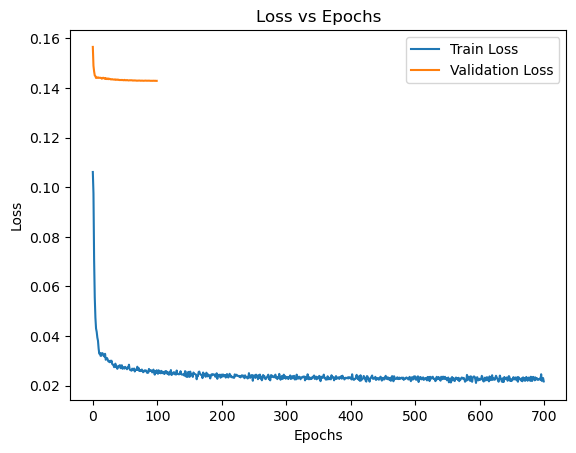

(12736,) (12736,)


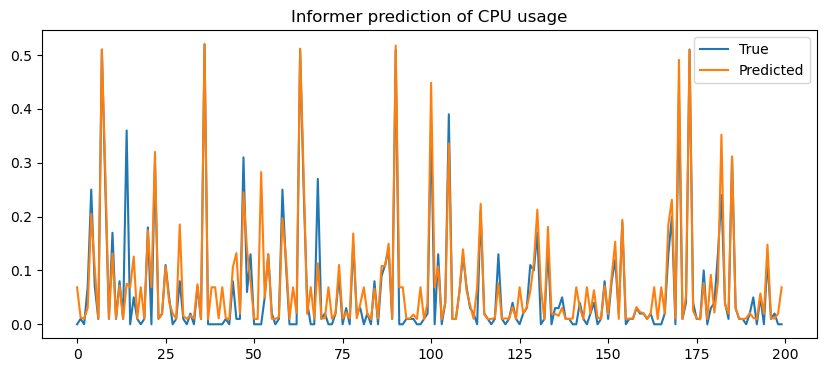

In [ ]:
if TRAINING_INFORMER:
    true_y = []
    pred_y = []
    with torch.no_grad():
        for i, (input, real_val) in enumerate(val_loader):
            # input, real_val = input.astype(torch.float32), real_val.astype(torch.float32)
            
            input, real_val = input.to(device), real_val.to(device)
            input =input.squeeze(-1)
            real_val =real_val.squeeze(-1)
            input = input.transpose(1, 2)
            real_val = real_val.transpose(1, 2)
            trainer.model.eval()
            # input = nn.functional.pad(input,(1,0,0,0))
            output = trainer.model(input) #  [batch_size,seq_length,num_nodes,1]
            real_val = real_val.squeeze(1)
            predict = trainer.scaler.inverse_transform(output)
            predict = predict.cpu().numpy()
            real_val = real_val.cpu().numpy()
            true_y.append(real_val)
            pred_y.append(predict)
            break
    
    y_pred_rescaled = np.concatenate(pred_y, axis=0)
    y_test_rescaled = np.concatenate(true_y, axis=0)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.figure(figsize=(10, 4))
    y_pred_rescaled =  y_pred_rescaled.flatten()
    y_test_rescaled =  y_test_rescaled.flatten()  # 合并测试结果
    print(y_pred_rescaled.shape, y_test_rescaled.shape)
    y_pred_rescaled = np.clip(y_pred_rescaled, 0, 1)
    y_test_rescaled = np.clip(y_test_rescaled, 0, 1)
    plt.plot(y_test_rescaled[:200], label='True')
    plt.plot(y_pred_rescaled[:200], label='Predicted')
    plt.legend()
    plt.title('Informer prediction of CPU usage')
    plt.show()

In [ ]:
if TRAINING_GWNET:
    import scipy.sparse as sp
    import pickle
    from scipy.sparse import linalg
    
    def sym_adj(adj):
        """Symmetrically normalize adjacency matrix."""
        adj = sp.coo_matrix(adj)
        rowsum = np.array(adj.sum(1))
        d_inv_sqrt = np.power(rowsum, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
        return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).astype(np.float32).todense()

    def asym_adj(adj):
        adj = sp.coo_matrix(adj)
        rowsum = np.array(adj.sum(1)).flatten()
        d_inv = np.power(rowsum, -1).flatten()
        d_inv[np.isinf(d_inv)] = 0.
        d_mat= sp.diags(d_inv)
        return d_mat.dot(adj).astype(np.float32).todense()
    def calculate_normalized_laplacian(adj):
        """
        # L = D^-1/2 (D-A) D^-1/2 = I - D^-1/2 A D^-1/2
        # D = diag(A 1)
        :param adj:
        :return:
        """
        adj = sp.coo_matrix(adj)
        d = np.array(adj.sum(1))
        d_inv_sqrt = np.power(d, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
        normalized_laplacian = sp.eye(adj.shape[0]) - adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
        return normalized_laplacian
    def load_pickle(pickle_file):
        try:
            with open(pickle_file, 'rb') as f:
                pickle_data = pickle.load(f)
        except UnicodeDecodeError as e:
            with open(pickle_file, 'rb') as f:
                pickle_data = pickle.load(f, encoding='latin1')
        except Exception as e:
            print('Unable to load data ', pickle_file, ':', e)
            raise
        return pickle_data
    def calculate_scaled_laplacian(adj_mx, lambda_max=2, undirected=True):
        if undirected:
            adj_mx = np.maximum.reduce([adj_mx, adj_mx.T])
        L = calculate_normalized_laplacian(adj_mx)
        if lambda_max is None:
            lambda_max, _ = linalg.eigsh(L, 1, which='LM')
            lambda_max = lambda_max[0]
        L = sp.csr_matrix(L)
        M, _ = L.shape
        I = sp.identity(M, format='csr', dtype=L.dtype)
        L = (2 / lambda_max * L) - I
        return L.astype(np.float32).todense()
    def load_adj(pkl_filename, adjtype):
        sensor_ids, sensor_id_to_ind, adj_mx = load_pickle(pkl_filename)
        if adjtype == "scalap":
            adj = [calculate_scaled_laplacian(adj_mx)]
        elif adjtype == "normlap":
            adj = [calculate_normalized_laplacian(adj_mx).astype(np.float32).todense()]
        elif adjtype == "symnadj":
            adj = [sym_adj(adj_mx)]
        elif adjtype == "transition":
            adj = [asym_adj(adj_mx)]
        elif adjtype == "doubletransition":
            adj = [asym_adj(adj_mx), asym_adj(np.transpose(adj_mx))]
        elif adjtype == "identity":
            adj = [np.diag(np.ones(adj_mx.shape[0])).astype(np.float32)]
        else:
            error = 0
            assert error, "adj type not defined"
        return sensor_ids, sensor_id_to_ind, adj
    def make_graph_inputs(args, device):
        sensor_ids, sensor_id_to_ind, adj_mx = load_adj(args.adjdata, args.adjtype)
        supports = [torch.tensor(i).to(device) for i in adj_mx]
        aptinit = None if args.randomadj else supports[0]  # ignored without do_graph_conv and add_apt_adj
        if args.aptonly:
            if not args.addaptadj and args.do_graph_conv: raise ValueError(
                'WARNING: not using adjacency matrix')
            supports = None
        return aptinit, supports

In [ ]:
from argparse import Namespace

from torchinfo import summary

if TRAINING_GWNET:
    args = Namespace(device='cuda:0', data='dataset/fromCloudToEdge/mini_split/', adjdata='dataset/fromCloudToEdge/mini_split/adj_mx.pkl', adjtype='doubletransition', do_graph_conv=True, aptonly=False, addaptadj=True, randomadj=True, seq_length=1, nhid=40, in_dim=1, num_nodes=199, batch_size=64, dropout=0.3, n_obs=None, apt_size=10, cat_feat_gc=False, fill_zeroes=True, checkpoint=None, epochs=100, clip=3, weight_decay=0.0001, learning_rate=0.001, lr_decay_rate=0.97, save='logs/baseline_v2', n_iters=None, es_patience=20)
    aptinit, supports = make_graph_inputs(args, device)
    print(supports[0].shape)
    model = GWNet.from_args(args, device, supports, aptinit, blocks=4, layers=3)
    print(f"GWNET model initialized successfully.")
    model.to(device)
    
    # summary(model, input_size=(64, 2, 207, 12))
    # print(summary(model, input_size=(64, 1, 199, 20)))

torch.Size([199, 199])
GWNET model initialized successfully.


/tmp/ipykernel_3996854/3052553235.py:18: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -1).flatten()


In [ ]:
if TRAINING_GWNET:
    trainer = Trainer.from_args(model, scaler, args=args)
    print(f"GWNet trainer initialized successfully")
    epochs_since_best_mae = 0
    # Training loop
    train_loss, train_mape, train_rmse = [], [], []
    val_loss, val_mape, val_rmse = [], [], []
    lowest_mae = float('inf')
    with tqdm.tqdm(total=args.epochs * len(train_loader)) as pbar:
        for epoch in range(args.epochs):
            for i, (input, real_val) in enumerate(train_loader):
                input, real_val = input.to(device), real_val.to(device)
                input = input.transpose(1, 2)
                input = input.transpose(1, 3)
                real_val = real_val.transpose(1, 2)
                real_val = real_val.transpose(1, 3)
                # print(f"input shape: {input.shape}, real_val shape: {real_val.shape}")
                mae, mape, rmse = trainer.train(input, real_val, tranponse=True)
                train_loss.append(mae)
                train_mape.append(mape)
                train_rmse.append(rmse)
                pbar.update(1)
            trainer.scheduler.step()
            # Evaluate on validation set
            with torch.no_grad():
                for i, (input, real_val) in enumerate(val_loader):
                    input, real_val = input.to(device), real_val.to(device)
                    input = input.transpose(1, 2)
                    input = input.transpose(1, 3)
                    real_val = real_val.transpose(1, 2)
                    real_val = real_val.transpose(1, 3)
                    mae, mape, rmse = trainer.eval(input, real_val)
                    # print()
                    val_loss.append(mae)
                    val_mape.append(mape)
                    val_rmse.append(rmse)
            # Check if current validation loss is the lowest
            if np.mean(val_mape) < lowest_mae:
                lowest_mae = np.mean(val_mape)
                torch.save(model.state_dict(), 'best_GwNet_model.pth')
                epochs_since_best_mae = 0
            else:
                epochs_since_best_mae += 1
            if epochs_since_best_mae >= args.es_patience: break
            # print(f"Epoch {epoch+1}/{EPOCH}, Train Loss: {np.mean(train_loss):.4f}, Train MAPE: {np.mean(train_mape):.4f}, Train RMSE: {np.mean(train_rmse):.4f}")
    print(f"Training completed. Final Train Loss: {train_loss[-1]:.4f}, Train MAPE: {train_mape[-1]:.4f}, Train RMSE: {train_rmse[-1]:.4f}")

GWNet trainer initialized successfully


100%|██████████| 700/700 [02:47<00:00,  4.17it/s]

Training completed. Final Train Loss: 0.0299, Train MAPE: 0.4106, Train RMSE: 0.0650


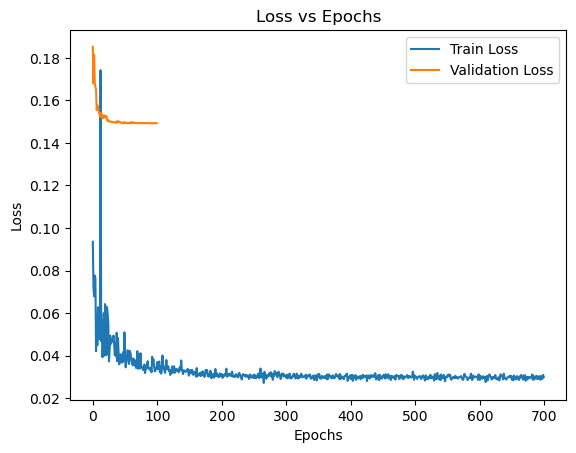

(12736,) (12736,)


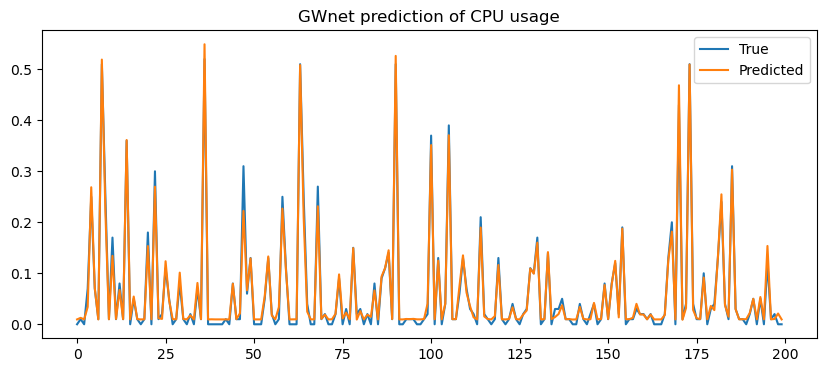

In [ ]:
if TRAINING_GWNET:
    true_y = []
    pred_y = []
    with torch.no_grad():
        for i, (input, real_val) in enumerate(val_loader):
            # input, real_val = input.astype(torch.float32), real_val.astype(torch.float32)
            
            input, real_val = input.to(device), real_val.to(device)
            input = input.transpose(1, 2)
            input = input.transpose(1, 3)
            real_val = real_val.transpose(1, 2)
            real_val = real_val.transpose(1, 3)
            trainer.model.eval()
            # input = nn.functional.pad(input,(1,0,0,0))
            output = trainer.model(input) #  [batch_size,seq_length,num_nodes,1]
            # real_val = real_val.squeeze(1)
            predict = trainer.scaler.inverse_transform(output)
            predict = predict.cpu().numpy()
            real_val = real_val.cpu().numpy()
            true_y.append(real_val)
            pred_y.append(predict)
            break
    
    y_pred_rescaled = np.concatenate(pred_y, axis=0)
    y_test_rescaled = np.concatenate(true_y, axis=0)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.figure(figsize=(10, 4))
    y_pred_rescaled =  y_pred_rescaled.flatten()
    y_test_rescaled =  y_test_rescaled.flatten()  # 合并测试结果
    print(y_pred_rescaled.shape, y_test_rescaled.shape)
    y_pred_rescaled = np.clip(y_pred_rescaled, 0, 1)
    y_test_rescaled = np.clip(y_test_rescaled, 0, 1)
    plt.plot(y_test_rescaled[:200], label='True')
    plt.plot(y_pred_rescaled[:200], label='Predicted')
    plt.legend()
    plt.title('GWnet prediction of CPU usage')
    plt.show()